https://arxiv.org/abs/2007.14044

In [36]:
!pip3 install qiskit --upgrade

In [37]:
import qiskit
from scipy.special import erfinv
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split

qs = qiskit.Aer.get_backend('qasm_simulator')

# IRIS

### Dataset

In [38]:
diconvert = {
    "Iris-setosa" : "00",
    "Iris-versicolor" : "01",
    "Iris-virginica" : "10",
    "NaN" : "11"
}

dicinv = {diconvert[k] : k for k in diconvert} 

In [39]:
def qFactor(eps, d):
    return erfinv(1-eps**(1/d)/2)

In [40]:
eps = 0.01
alpha = 0.1
d = 4
q = qFactor(eps, d)

In [41]:
q

0.9980412728799112

In [42]:
def standardise(x):
    return (x-np.mean(x))/np.std(x)

def rescaleFeature(x):
    return (1-alpha/2)*(np.pi/q)*standardise(x)

In [43]:
df = pd.read_csv("iris.data")
attributes = df.columns[:-1]
for x in attributes:
    df[x] = rescaleFeature(df[x])

### Circuit

In [44]:
def psiGate(qc, param, bit):
    qc.rx(np.pi/2, bit)
    qc.rz(param, bit)
    qc.rx(np.pi/2, bit)

In [52]:
def irisCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2)
    for i in range(4):
        if i : qc.cz(0, 1)
        psiGate(qc, omega[(2*i) % 4], 0)
        psiGate(qc, omega[(2*i+1) % 4], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(2*i)], 0)
        psiGate(qc, theta[(2*i+1)], 1)
    return qc

In [53]:
def predictionDict(theta, omega, nshots = 100):
    
    qc = qiskit.QuantumCircuit(2, 2)
    qc.append(irisCircuit(theta, omega), range(2))
    qc.measure(range(2), range(2))
    
    job = qiskit.execute(qc, shots=nshots, backend=qs)
    c = job.result().get_counts()
    
    return c


In [54]:
def lossFunction(theta, data, nshots=100):
    omega = data[attributes].values
    label = diconvert[data["class"]]
    c = predictionDict(theta, omega)
    
    if label in c:
        e = np.exp(c[label]/nshots)
    else :
        e = 1
    s = np.exp(np.array(list(c.values()))/nshots).sum()
    return -np.log(e/s)


In [55]:
def lossBatch(theta, batch, nshots=100):
    s = batch.apply(
        lambda data : lossFunction(theta, data, nshots=nshots),
        axis=1
    )
    return s.mean()                

In [56]:
train_size = 90
test_size = 60

trainSet, testSet = train_test_split(
    df, test_size=test_size, train_size=train_size, stratify = df[["class"]])
testSet = pd.DataFrame(testSet)
trainSet= pd.DataFrame(trainSet)

In [57]:
def fit(train_set, nshots=100, maxiter=20, x=None):
    if x is None:
        x = np.random.uniform(-np.pi, np.pi, 8)
    opt = sp.optimize.minimize(
        fun=lambda theta : lossBatch(theta, trainSet, nshots=nshots),
        x0 = x,
        method='COBYLA',
        options={'maxiter': maxiter}
    )
    return opt

In [58]:
opt = fit(trainSet, nshots=250, maxiter=20)
new_t = opt.x
opt

     fun: 1.2231008727699302
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 20
  status: 2
 success: False
       x: array([-1.06908829,  0.50742429, -1.10651772, -1.550264  ,  3.76656074,
       -1.65519488, -1.66592888, -0.82393337])

In [59]:
opt = fit(trainSet, nshots=500, maxiter=30)
new_t = opt.x
opt

     fun: 1.2010522728946589
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 30
  status: 2
 success: False
       x: array([-2.17546612,  0.09782192,  1.28325372,  0.31547863,  2.51081862,
        1.21235548, -3.60998167,  1.26076247])

In [60]:
opt = fit(trainSet, nshots=500, maxiter=70)
theta_opt = opt.x
opt

     fun: 1.1876838915911934
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 70
  status: 2
 success: False
       x: array([ 0.14894465,  2.82410125,  2.56052379, -2.56910202,  2.31776421,
       -2.71525959,  1.03026264, -1.26934638])

In [61]:
def argmaxDict(c):
    v = None
    for key in c :
        if v is None or c[key] >= v:
            k = key
            v = c[key]
    return k

In [62]:
def prediction(theta, omega):
    return argmaxDict(predictionDict(theta, omega))

In [63]:
def predictedClass(data):
    omega = data[attributes].values.T
    ypred = prediction(theta_opt, omega)
    return dicinv[ypred]

In [64]:
testSet["predicted"] = testSet.apply(
    lambda row : dicinv[prediction(theta_opt, row[attributes].values)],
    axis=1
)

In [65]:
sum(np.array(testSet["class"] == testSet["predicted"]))/60

0.36666666666666664

In [66]:
trainSet["predicted"] = trainSet.apply(
    lambda row : dicinv[prediction(theta_opt, row[attributes].values)],
    axis=1
)

In [ ]:
sum(np.array(trainSet["class"] == trainSet["predicted"]))/60

# Gaussian XOR

### Dataset

In [3]:
import numpy as np

In [76]:
def generate_gaussian_point(x, y, label) :
    pick_x = np.random.normal(loc=x, scale = 0.5)
    pick_y = np.random.normal(loc=y, scale = 0.5)
    return (pick_x, pick_y, label)

In [77]:
point1 = (-np.pi / 2, 0)
point2 = (np.pi / 2, 0)
point3 = (0, -np.pi / 2)
point4 = (0, np.pi / 2)

centers = [point1, point2, point3, point4]


In [78]:
points = []
for i in range(20) :
    points.append(generate_gaussian_point(*point1, 0))
    points.append(generate_gaussian_point(*point2, 0))
    points.append(generate_gaussian_point(*point3, 1))
    points.append(generate_gaussian_point(*point4, 1))


(-3.141592653589793, 3.141592653589793)

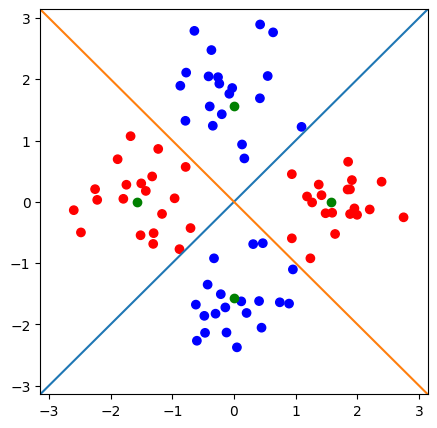

In [79]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5,5]

x,y,c = zip(*points)
c = ["red" if el==0 else "blue" for el in c]
plt.scatter(x, y, color=c)
x,y = zip(*centers)
plt.scatter(x, y, color='green')



x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

In [81]:
points

[(-2.217557694674133, 0.03114968272236184, 0),
 (1.2670395265772538, -0.010985743698995317, 0),
 (0.047819856462581134, -2.375572091741907, 1),
 (-0.8697314691863324, 1.893592355833411, 1),
 (-1.326367947634389, 0.413407441205147, 0),
 (1.9959091772031468, -0.21282562465938812, 0),
 (-0.12116806544165501, -2.133952075333033, 1),
 (-0.6418962966951353, 2.7894468906325285, 1),
 (-0.7043354682983374, -0.4292814887786577, 0),
 (1.88065762187855, 0.20248032302949465, 0),
 (-0.213595080950215, -1.5081263622162164, 1),
 (-0.7750072524693712, 2.108231709016426, 1),
 (-0.7833743686522177, 0.5687712602344087, 0),
 (1.1844804678085383, 0.08665382874899479, 0),
 (0.9554378362891315, -1.1038797343121343, 1),
 (0.13080299351324648, 0.9351454094249616, 1),
 (-1.3027369835503626, -0.5121762828641984, 0),
 (1.912441574117965, 0.3539528507766015, 0),
 (0.3111910927775056, -0.690895511107663, 1),
 (-0.3928153495187432, 1.55610787584115, 1),
 (-1.1665234356781464, -0.1982248313094562, 0),
 (0.938570446624

In [80]:
def xorCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2)
    psiGate(qc, omega[0], 0)
    psiGate(qc, omega[1], 1)
    for i in range(2):
        qc.cz(0, 1)
        psiGate(qc, theta[2*i], 0)
        psiGate(qc, theta[2*i+1], 1)
    return qc

# Skin segmentation

In [66]:
def skinSegCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(3)
    psiGate(qc, omega[0], 0)
    psiGate(qc, omega[1], 1)
    psiGate(qc, omega[2], 2)
    
    qc.cz(0, 2)
    
    psiGate(qc, theta[0], 0)
    psiGate(qc, theta[1], 2)
    
    qc.cz(0, 1)
    
    psiGate(qc, theta[2], 0)
    psiGate(qc, theta[3], 1)
    
    qc.cz(1, 2)
    
    psiGate(qc, theta[4], 1)
    psiGate(qc, theta[5], 2)
    return qc

# Synthetic dataset with 4 classes

In [ ]:
def syntheticCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2)
    for i in range(2):
        if i : qc.cz(0, 1)
        psiGate(qc, omega[0], 0)
        psiGate(qc, omega[1], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i)], 0)
        psiGate(qc, theta[(6*i+1)], 1)
        qc.cz(0, 1)
        psiGate(qc, omega[0], 0)
        psiGate(qc, omega[1], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i+2)], 0)
        psiGate(qc, theta[(6*i+3)], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i+4)], 0)
        psiGate(qc, theta[(6*i+5)], 1)
    return qc

# Run on IBM Quantum Computer

In [67]:
TOKEN = ...

In [68]:
qiskit.IBMQ.save_account(TOKEN, overwrite=True) 
provider = qiskit.IBMQ.load_account()
backend = qiskit.providers.ibmq.least_busy(provider.backends())

mapped_circuit = qiskit.transpile(circuit, backend=backend)
qobj = qiskit.assemble(mapped_circuit, backend=backend, shots=1024)

IBMQAccountCredentialsInvalidToken: 'Invalid IBM Quantum Experience token found: "Ellipsis" of type <class \'ellipsis\'>.'

In [ ]:
# execute the circuit
job = backend.run(qobj)


In [ ]:
job.status()


In [ ]:
ID = job.job_id()

In [ ]:
job = backend.retrieve_job(ID)

In [ ]:
result = job.result()

In [ ]:
counts = result.get_counts()

In [ ]:
counts